In [29]:
import torch
import torchvision


print(torchvision.__version__)
print(torch.__version__)

0.21.0
2.6.0


In [30]:
try:
    import going_modular
    
except: 
    print("not found")
    !git clone git@github.com:mrdbourke/pytorch-deep-learning.git
    !mv pytorch-deep-learning/going_modular . 
    !rm -rf pytorch-deep-learning


In [31]:
from going_modular.going_modular import engine, data_setup

device = "cuda" if torch.cuda.is_available() else "mps"

device

'mps'

In [32]:
# Get data
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

image_path

# If image folder doesnt exist download

if image_path.is_dir():
    print("Path exist... skipping downlaod")
else:
    print("make dir and Download the file")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # download the zip and write it down
    
    with open("data/pizza_steak_sushi.zip", "wb") as f:
        req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(req.content)
    

# Now unzip the file
# with  zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as f:
#     f.extractall(image_path)
#     os.remove(data_path/"pizza_steak_sushi.zip")
    
    



Path exist... skipping downlaod


In [33]:
data_path,  image_path

(PosixPath('data'), PosixPath('data/pizza_steak_sushi'))

In [34]:
# setup the directory path

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [35]:
# convert the dir data into dataloaders
from going_modular.going_modular import data_setup
from torchvision import transforms

# manual transfrom 
normalize  =  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    normalize
])
BATCH_SIZE = 32
train_data_loader, test_data_loader, class_names =  data_setup.create_dataloaders(train_dir,test_dir,manual_transform, BATCH_SIZE, 1)

In [36]:
# Automatic transform
from torchvision.models import EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT

auto_transfrom = weights.transforms()

auto_transfrom

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [37]:
BATCH_SIZE = 32
train_data_loader, test_data_loader, class_names =  data_setup.create_dataloaders(train_dir,test_dir,auto_transfrom, BATCH_SIZE, 1)

In [38]:
# Getting a pre-trained model
weights = EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [39]:
from torchinfo import summary

summary(model=model, 
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [40]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [41]:
# lets freeze the fetures of model

for param in model.features.parameters():
    param.requires_grad = False
    print(param)

Parameter containing:
tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
          [-1.1092e-01, -6.1004e-01, -3.3345e-01],
          [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],

         [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
          [-1.3646e-01, -1.5367e+00, -1.5937e+00],
          [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],

         [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
          [-1.1966e-01, -2.8122e-01, -2.1883e-01],
          [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],


        [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
          [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
          [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],

         [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
          [ 1.6213e+00, -2.1188e+00,  4.1014e-01],
          [ 1.7230e+00, -2.0756e+00,  3.3958e-01]],

         [[ 9.5290e-02, -1.5971e-01,  7.4559e-02],
          [ 8.0502e-01, -9.7034e-01,  2.6280e-01],
          [ 7.1944e-01, -1.0026e+00,  1.9870e-01]]],


        [[[ 5.3857e-02,  2.6367e-01,  1.1696

In [42]:
from torchinfo import summary

summary(model=model, 
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [43]:
1281000/ 5288548 * 100

24.222149444422175

In [44]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [45]:
from torch import nn
model.classifier = nn.Sequential(
   nn.Dropout(p=0.2, inplace=True),
   nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

In [46]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [47]:
from torchinfo import summary

summary(model=model, 
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [48]:
# Train model
from torch.optim import Adam
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [49]:
from going_modular.going_modular import engine
from timeit import default_timer as timer 
start = timer()
results = engine.train(model=model,
             train_dataloader=train_data_loader,
             test_dataloader=test_data_loader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=4,
             device=device
             )

end = timer()
print(f"[INFO] The time took : {end-start:.3f}")

 25%|██▌       | 1/4 [00:14<00:42, 14.10s/it]

Epoch: 1 | train_loss: 1.0054 | train_acc: 0.5820 | test_loss: 0.8713 | test_acc: 0.8258


 50%|█████     | 2/4 [00:28<00:28, 14.02s/it]

Epoch: 2 | train_loss: 0.8471 | train_acc: 0.6445 | test_loss: 0.7313 | test_acc: 0.8258


 75%|███████▌  | 3/4 [00:41<00:13, 13.94s/it]

Epoch: 3 | train_loss: 0.7337 | train_acc: 0.7148 | test_loss: 0.6026 | test_acc: 0.9062


100%|██████████| 4/4 [00:55<00:00, 13.93s/it]

Epoch: 4 | train_loss: 0.6933 | train_acc: 0.7695 | test_loss: 0.6041 | test_acc: 0.8769
[INFO] The time took : 55.964


In [50]:
# we need helper function  to plot the loss curve
import requests
try:
    import helper.py
    
except:
    print("Please download it first")
    with open("helper.py", "wb") as f:
        res = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
        f.write(res.content)
        


Please download it first


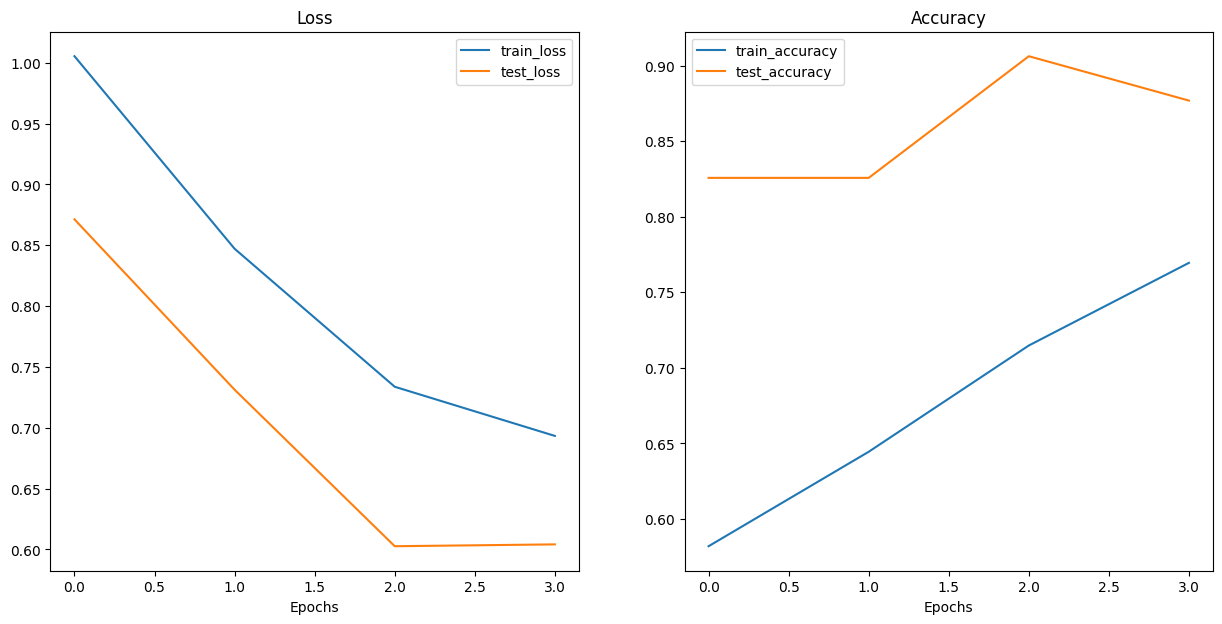

In [51]:
from helper import plot_loss_curves

plot_loss_curves(results=results)